In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [193]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [194]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [195]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [196]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [197]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [198]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [217]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

#### 整理store数据

In [199]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [200]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


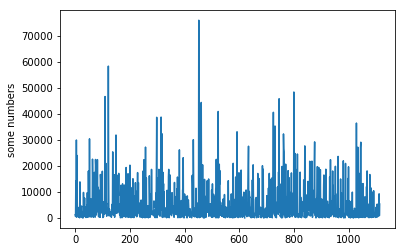

In [201]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.plot(store['CompetitionDistance'])
plt.ylabel('some numbers')
plt.show()


In [202]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [203]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

351


In [204]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(0)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [205]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [206]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [207]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [208]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [209]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [210]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [211]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [212]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [213]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,"0,0,0,0",1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,"0,3,6,9",1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,"0,3,6,9",1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,"0,0,0,0",0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,"0,0,0,0",1,0,0,1,0,0,0


In [214]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 15 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int32(5), int64(2), object(1), uint8(7)
memory usage: 55.6+ KB


#### 整理train数据

In [218]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [225]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [228]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [229]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [232]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [233]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [234]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [238]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [244]:
len(test.query('Open==1'))

35104

In [242]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [243]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 25 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval                35104 non-nu

In [246]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 26 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64